In [35]:
import numpy as np
import scipy as _sp
import d3s.observables as observables
import d3s.domain as domain
import d3s.systems as systems
import d3s.algorithms as algorithms
import d3s.kernels as _kernels
from scipy.spatial import distance
import matplotlib.pyplot as plt
from typing import NewType

KoopmanMatrix         = NewType("KoopmanMatrix", np.ndarray)
Vector                = NewType("Vector", np.ndarray)
MonomialObservable    = NewType("MonomialObservable", observables.monomials)
Matrix                = NewType("Matrix", np.ndarray)
Scalar                = NewType("Scalar", float)

np.random.seed(seed=233423)
# define domain
#bounds = np.array([[-20, 20], [-20, 20], [-20, 20]])
#boxes = np.array([20, 20, 20])
#Omega = domain.discretization(bounds, boxes)
bounds = np.array([[-2, 2], [-2, 2]])
boxes = np.array([30, 30])
Omega = domain.discretization(bounds, boxes)

# データ生成
#f = systems.Hydrogen(1e-3, 10000)
f = systems.DoubleWell2D(1e-3, 10000)
m = 5000
# generate training data
#X = np.random.randn(2, m)
#r = 20*np.random.rand(m)**(1/3)
#for i in range(m):
#    X[:, i] = r[i]*X[:, i]/np.linalg.norm(X[:, i])
X = Omega.rand(m)
Y = f(X) 

# choose observables
#psi = observables.gaussians(Omega, 0.2)
psi = observables.monomials(15)
#psi = observables.indicators(Omega)

evs = 4 # number of eigenvalues/eigenfunctions to be computed
PsiC = psi(Omega.midpointGrid()) # observables evaluated at midpoints of the grid
print(PsiC.shape)

(136, 900)


In [ ]:
def gaussian(x: Vector, y: Vector, sigma: Scalar) -> Scalar:
    return np.exp(-np.linalg.norm(x-y)**2/(2*sigma**2))

def online_kernel_update(K: KoopmanMatrix, P: Matrix, X: Vector, Y: Vector, sigma: Scalar, size: int) -> Vector:
    #G_Q = np.ones([size, size]) * gaussian(Y, X, sigma)
    #G_P = np.ones([size, size]) * gaussian(X, X, sigma)
    #gamma = 1/(1 + gaussian(X, X, sigma) * np.sum(G))
    #K = K + gamma * (G_Q - K @ G_P) @ G
    #G = G - gamma * G_P @ G
    
    G_Q = gramian2(Y, X, sigma)
    G_P = gramian(X, sigma)
    gamma = 1/(1 + gaussian(X, X, sigma) * np.sum(G))
    K = K + gamma * (G_Q - K @ G_P) @ G
    P = P - gamma * G_P @ P
    
    return (K, G)

def edmd(X, Y, psi, evs=5, operator='K'):
    '''
    Conventional EDMD for the Koopman or Perron-Frobenius operator. The matrices X and Y
    contain the input data.

    :param psi:      set of basis functions, see d3s.observables
    :param evs:      number of eigenvalues/eigenvectors
    :param operator: 'K' for Koopman or 'P' for Perron-Frobenius
    :return:         eigenvalues d and corresponding eigenvectors V containing the coefficients for the eigenfunctions
    '''
    PsiX = psi(X)
    PsiY = psi(Y)
    C_0 = PsiX @ PsiX.T
    C_1 = PsiY @ PsiX.T
    if operator == 'P': C_1 = C_1.T
    #pesudo-inverse: X.T @ (X @ X.T)^-1
    A = C_1 @ np.linalg.pinv(C_0)
    d, V = sortEig(A, evs)
    return (A, d ,V)

def kedmd(X, Y, k, epsilon=0, evs=5, operator='K'):
    '''
    Kernel EDMD for the Koopman or Perron-Frobenius operator. The matrices X and Y
    contain the input data.

    :param k:        kernel, see d3s.kernels
    :param epsilon:  regularization parameter
    :param evs:      number of eigenvalues/eigenvectors
    :param operator: 'K' for Koopman or 'P' for Perron-Frobenius (note that the default is P here)
    :return:         eigenvalues d and eigenfunctions evaluated in X
    '''
    if isinstance(X, list): # e.g., for strings
        n = len(X)
    else:
        n = X.shape[1]

    G_0 = gramian(X, k)
    G_1 = gramian2(X, Y, k)
    A = G_1 @ np.linalg.pinv(G_0 + epsilon*np.eye(n))
    d, V = sortEig(A, evs)
    #if operator == 'K': V = G_0 @ V
    return (A, d, V, G_0)

def sortEig(A, evs=5, which='LM'):
    '''
    Computes eigenvalues and eigenvectors of A and sorts them in decreasing lexicographic order.

    :param evs: number of eigenvalues/eigenvectors
    :return:    sorted eigenvalues and eigenvectors
    '''
    n = A.shape[0]
    if evs < n:
        #左固有ベクトルを求める
        d, V = _sp.sparse.linalg.eigs(A.T, evs, which=which)
        #V = np.conjugate(V).T
        #d, V = _sp.linalg.eig(A.T, left=True, right=False)
    else:
        d, V = _sp.linalg.eig(A)
    ind = d.argsort()[::-1] # [::-1] reverses the list of indices
    return (d[ind], V[:, ind])

def gramian(X, k="gaussianKernel", sigma=np.sqrt(2)):
    '''Compute Gram matrix for training data X with kernel k.'''
    name = k
    if name == 'gaussianKernel':
        return np.exp(-distance.squareform(distance.pdist(X.T, 'sqeuclidean'))/(2*sigma**2))
    elif name == 'laplacianKernel':
        return np.exp(-distance.squareform(distance.pdist(X.T, 'euclidean'))/sigma)
    elif name == 'polynomialKernel':
        return (k.c + X.T @ X)**k.p

def gramian2(X, Y, k="gaussianKernel", sigma=np.sqrt(2)):
    '''Compute Gram matrix for training data X and Y with kernel k.'''
    name = k
    if name == 'gaussianKernel':
        #print('Gaussian kernel with sigma = %f.' % k.sigma)
        return np.exp(-distance.cdist(X.T, Y.T, 'sqeuclidean')/(2*sigma**2))
    elif name == 'laplacianKernel':
        #print('Laplacian kernel with sigma = %f.' % k.sigma)
        return np.exp(-distance.cdist(X.T, Y.T, 'euclidean')/sigma)
    elif name == 'polynomialKernel':
        #print('Polynomial kernel with degree = %f and c = %f.' % (k.p, k.c))
        return (k.c + X.T@Y)**k.p

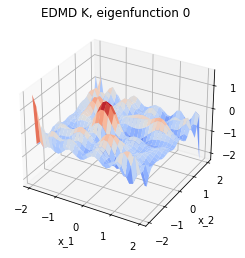

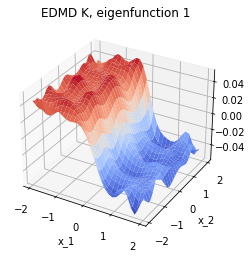

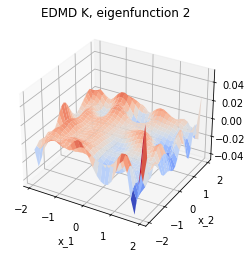

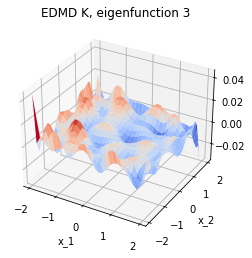

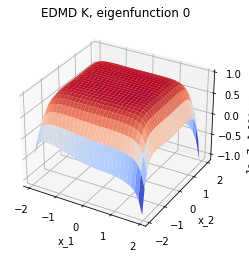

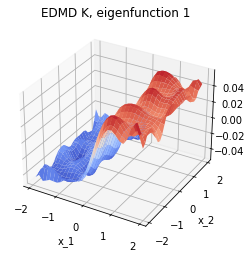

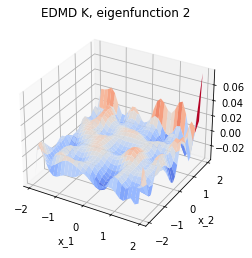

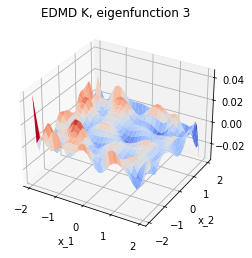

In [5]:
A_k, d_k, V_k = edmd(X, Y, psi, operator='K', evs=evs)
for i in range(evs):
    plt.figure()
    r = np.real(V_k[:, i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('EDMD K, eigenfunction %d' % i)
    
A_0, d_0, V_0 = algorithms.edmd(X, Y, psi, operator='K', evs=evs)
for i in range(evs):
    plt.figure()
    r = np.real(V_0[:, i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('EDMD K, eigenfunction %d' % i)

In [48]:
sigma = np.sqrt(2)

init_size = 4999
X_base = X[:, :init_size]
Y_base = Y[:, :init_size]
PsiX = psi(X_base)
size = PsiX.shape[0]
k = 'gaussianKernel'
P = gramian(X, k)
K, d, V, G_0 = kedmd(X_base, Y_base, evs=evs, k=k)

for i in range(m-init_size):
    X_add = X[:, init_size+i].reshape(-1,1)
    Y_add = Y[:, init_size+i].reshape(-1,1)
    K, P = online_kernel_update(K, P, X_add, Y_add, sigma, size)
d, V = sortEig(K, evs)
V = G_0 @ V
for i in range(evs):
    plt.figure()
    r = np.real(V[:, i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('online kernel EDMD K, eigenfunction %d' % i)

ValueError: not enough values to unpack (expected 4, got 3)

In [11]:
print(np.max(np.abs(V[:10, :10])-np.abs(V_k[:10, :10])))
print(d_k)
print(d_0)
print(d)

0.011747019810960048
[ 1.00000003+0.j          0.74793379+0.j          0.0859366 -0.02433969j
 -0.10799144+0.j        ]
[ 1.        +0.j          0.747933  +0.j          0.08593645-0.02433969j
 -0.10799017+0.j        ]
[58327982.16471209       +0.j         49285558.47038829+47667181.90105257j
 49285558.47038829-47667181.90105257j 11546435.80073162-46853139.18370659j]
